In [1]:
# Import Necessary Packages
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
batch_data = pd.read_csv("../../data/datasets/batch_meta_combine.csv")

X_train_scaled = pd.read_csv("../../data/datasets/X_train_scaled.csv",header=None)
X_train_scaled_oversample = pd.read_csv("../../data/datasets/X_train_scaled_oversample.csv",header=None)
X_val_scaled = pd.read_csv("../../data/datasets/X_val_scaled.csv",header=None)
X_test_scaled = pd.read_csv("../../data/datasets/X_test_scaled.csv",header=None)

X_test_herds = pd.read_csv("../../data/datasets/X_test_herds.csv")




y_train = pd.read_csv("../../data/datasets/y_train.csv")
y_train= y_train.replace("not_chronic",0)
y_train= y_train.replace("chronic",1)
y_train = pd.Series(list(y_train['group_class']))

y_train_oversample = pd.read_csv("../../data/datasets/y_train_oversample.csv")
y_train_oversample= y_train_oversample.replace("not_chronic",0)
y_train_oversample= y_train_oversample.replace("chronic",1)
y_train_oversample = pd.Series(list(y_train_oversample['group_class']))


y_val = pd.read_csv("../../data/datasets/y_val.csv")
y_val= y_val.replace("not_chronic",0)
y_val= y_val.replace("chronic",1)
y_val = pd.Series(list(y_val['group_class']))

y_test = pd.read_csv("../../data/datasets/y_test.csv")
y_test= y_test.replace("not_chronic",0)
y_test= y_test.replace("chronic",1)
y_test = pd.Series(list(y_test['group_class']))


num_features = 1600

# Subset X Data to top features
X_train_scaled = X_train_scaled.iloc[:, : num_features].values
X_train_scaled_oversample = X_train_scaled_oversample.iloc[:, : num_features].values
X_val_scaled = X_val_scaled.iloc[:, : num_features].values
X_test_scaled = X_test_scaled.iloc[:, : num_features].values


In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [24]:
first_layer_list = []
second_layer_list = []
dropout_layer_list = []
num_non_chronic_right = []
num_non_chronic_wrong = []
num_chronic_wrong = []
num_chronic_right = []

In [26]:
 for i in range(50,401,10):
    for j in range(25,100,5):
        for k in [.2,.25,.3,.35,.4]:
            model = tf.keras.models.Sequential([
              #tf.keras.layers.Flatten(input_shape=(28, 28)),
              tf.keras.layers.Dense(i, activation='relu'),
              tf.keras.layers.Dense(j, activation='relu'),    
               # tf.keras.layers.Conv2D(200),
              tf.keras.layers.Dropout(k),
              tf.keras.layers.Dense(2)
            ])

            model.compile(optimizer='adam',
                          loss=loss_fn,
                          metrics=['accuracy'])

            model.fit(X_train_scaled_oversample, y_train_oversample, epochs=20,verbose=0)


            probability_model = tf.keras.Sequential([
              model,
              tf.keras.layers.Softmax()
            ])

            predictions = probability_model.predict(X_val_scaled)

            y_pred = list()

            for pred in predictions:
                y_pred.append(np.argmax(pred))

            cf_matrix  = confusion_matrix(y_val, y_pred, labels=[0, 1])


            num_non_chronic_right.append(cf_matrix[0][0])
            num_non_chronic_wrong.append(cf_matrix[0][1])
            num_chronic_wrong.append(cf_matrix[1][0])
            num_chronic_right.append(cf_matrix[1][1])

            first_layer_list.append(i)
            second_layer_list.append(j)
            dropout_layer_list.append(k)


In [27]:
model_results = pd.DataFrame(
{'first_layer_val':first_layer_list,
    'second_layer_val':second_layer_list,
 'dropout_layer_val':dropout_layer_list,
 'non_chronic_right':num_non_chronic_right,
    'non_chronic_wrong':num_non_chronic_wrong,
 'num_chronic_right':num_chronic_right,
    'num_chronic_wrong':num_chronic_wrong,
}
)

In [36]:
model_results.sort_values(by=['num_chronic_right'],ascending=False)

model_results.to_csv("../../data/datasets/nn_model_results.csv")

In [39]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(25, activation='relu'),    
   # tf.keras.layers.Conv2D(200),
  tf.keras.layers.Dropout(.35),
  tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(X_train_scaled_oversample, y_train_oversample, epochs=20,verbose=0)


probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

predictions = probability_model.predict(X_test_scaled)

y_pred = list()

for pred in predictions:
    y_pred.append(np.argmax(pred))

cf_matrix  = confusion_matrix(y_test, y_pred, labels=[0, 1])
cf_matrix

array([[23,  5],
       [ 2,  6]], dtype=int64)

In [8]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

predictions = probability_model.predict(X_val_scaled)

y_pred = list()

for pred in predictions:
    y_pred.append(np.argmax(pred))

cf_matrix  = confusion_matrix(y_val, y_pred, labels=[0, 1])
cf_matrix

array([[20,  3],
       [ 7,  6]], dtype=int64)

In [10]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

predictions = probability_model.predict(X_test_scaled)

y_pred = list()

for pred in predictions:
    y_pred.append(np.argmax(pred))

cf_matrix  = confusion_matrix(y_test, y_pred, labels=[0, 1])

cf_matrix[0][0]

26

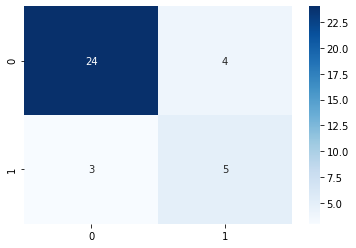

In [48]:

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [10]:
oversample_test_df = pd.DataFrame({
    "actual":y_test,
    "nn_prediction":y_pred,
    "herd":X_test_herds['herdx']
})

oversample_test_df.to_csv("../../data/datasets/nn_predictions.csv",index=False)